In [1]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models.neurlux import NeurLuxModel
from nebula.models.quovadis import QuoVadisModel
from nebula.models.dmds import DMDSGatedCNN
from nebula.models import TransformerEncoderChunks
from nebula.constants import SPEAKEASY_LABELMAP
REVERSE_SPEAKEASY_LABELMAP = {v: k for k, v in SPEAKEASY_LABELMAP.items()}
from collections import defaultdict
import numpy as np
import pickle
import json
import torch

RUN_NAME = "speakeasy"

INFOLDER = "out_speakeasy_multiclass"

RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]

NEBULA_VOCAB = 50000
NEURLUX_VOCAB = 10000
QUO_VADIS_VOCAB = 600
SEQ_LEN = 512
LIMIT = "full"

In [2]:
models = defaultdict(dict)

neurlux_vocab_file = os.path.join(INFOLDER, f"neurlux_{RUN_NAME}_vocab_{NEURLUX_VOCAB}_seqlen_{SEQ_LEN}", f"vocab_{NEURLUX_VOCAB}.json")
quo_vadis_data_folder = os.path.join(INFOLDER, f"quovadis_{RUN_NAME}_vocab_{QUO_VADIS_VOCAB}_seqlen_{SEQ_LEN}")
quo_vadis_vocab_name = [x for x in os.listdir(quo_vadis_data_folder) if x.startswith("vocab")][0]
quovadis_vocab_file = os.path.join(quo_vadis_data_folder, quo_vadis_vocab_name)
nebula_vocab_file = os.path.join(INFOLDER, f"nebula_{RUN_NAME}_vocab_{NEBULA_VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{NEBULA_VOCAB}_vocab.json")

with open(neurlux_vocab_file) as f:
    neurlux_vocab = json.load(f)
models['neurlux']['class'] = NeurLuxModel
models['neurlux']['config'] = {
    "embedding_dim": 256,
    "vocab_size": len(neurlux_vocab),
    "seq_len": SEQ_LEN,
    "num_classes": 8
}

models['quovadis']['class'] = QuoVadisModel
models['quovadis']['config'] = {
    "vocab": quovadis_vocab_file,
    "seq_len": SEQ_LEN,
    "num_classes": 8
}

models['dmds']['class'] = DMDSGatedCNN
models['dmds']['config'] = {
    "ndim": 98,
    "seq_len": SEQ_LEN,
    "num_classes": 8,
}

with open(nebula_vocab_file) as f:
    nebula_vocab = json.load(f)
models['nebula']['class'] = TransformerEncoderChunks
models['nebula']['config'] = {
    "vocab_size": len(nebula_vocab),
    "maxlen": SEQ_LEN,
    "chunk_size": 64,
    "dModel": 64,  # embedding & transformer dimension
    "nHeads": 8,  # number of heads in nn.MultiheadAttention
    "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
    "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    "numClasses": 8, # binary classification
    "hiddenNeurons": [64],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False,
    "norm_first": True
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
metrics_val = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]

    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
        print(f"[!] Loaded existing metrics from: {existing_pickle}")
    else:
        print(f"[!] In process: {key}")
        metrics = defaultdict(list)
        folder = os.path.join(INFOLDER, folder)
        print(f"[*] Reading data splits from: {folder}")
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_SPEAKEASY_LABELMAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                #print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

[!] Loaded existing metrics from: out_speakeasy_multiclass\dmds_roc_metrics_val_r1763_t5.pkl
[!] Loaded existing metrics from: out_speakeasy_multiclass\nebula_roc_metrics_val_r1763_t5.pkl
[!] Loaded existing metrics from: out_speakeasy_multiclass\neurlux_roc_metrics_val_r1763_t5.pkl
[!] Loaded existing metrics from: out_speakeasy_multiclass\quovadis_roc_metrics_val_r1763_t5.pkl


clean
              0.01       AUC        F1    Recall  Precision  Accuracy
dmds      0.114002  0.920885  0.879307  0.932985   0.833872  0.916612
nebula    0.447454  0.972893  0.961305  0.967613   0.955102  0.974752
neurlux   0.348600  0.975635  0.960859  0.979979   0.942521  0.974109
quovadis  0.460534  0.958050  0.946272  0.936779   0.956065  0.965531
backdoor
              0.01       AUC        F1    Recall  Precision  Accuracy
dmds      0.697381  0.845552  0.805897  0.695558   0.965290  0.951974
nebula    0.774952  0.920938  0.896454  0.849543   0.951042  0.971587
neurlux   0.658602  0.922327  0.892895  0.854517   0.945415  0.970404
quovadis  0.789767  0.892371  0.871144  0.788416   0.973434  0.966122
coinminer
              0.01       AUC        F1    Recall  Precision  Accuracy
dmds      0.553021  0.891672  0.800972  0.804144   0.812683  0.963364
nebula    0.880392  0.937070  0.908294  0.879875   0.938765  0.983908
neurlux   0.893842  0.944493  0.922978  0.893131   0.956921  0.98

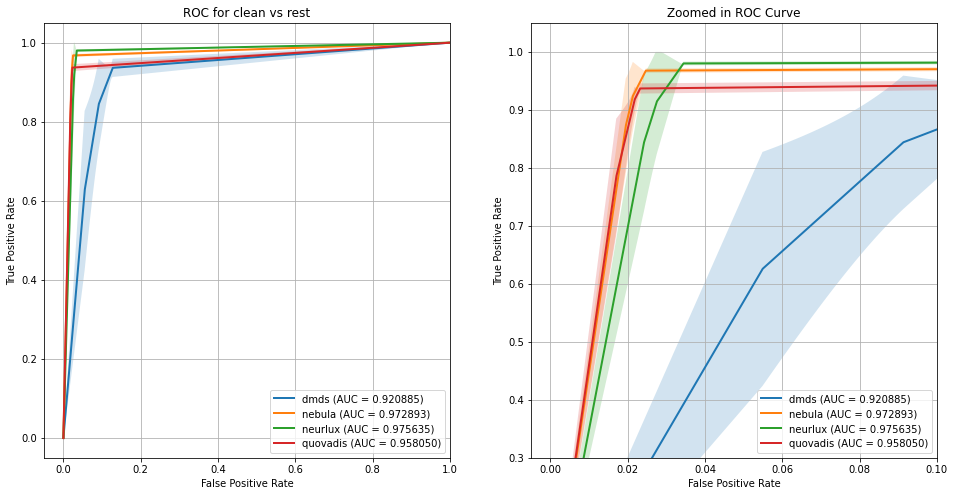

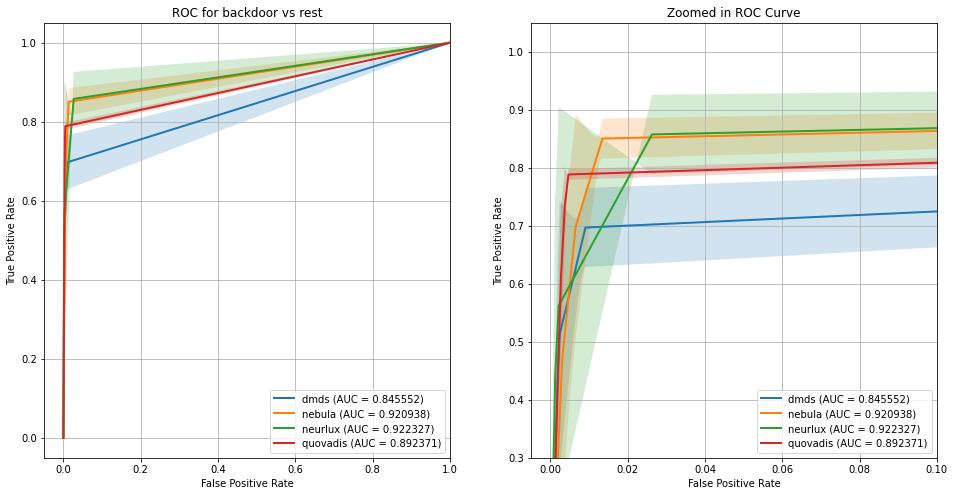

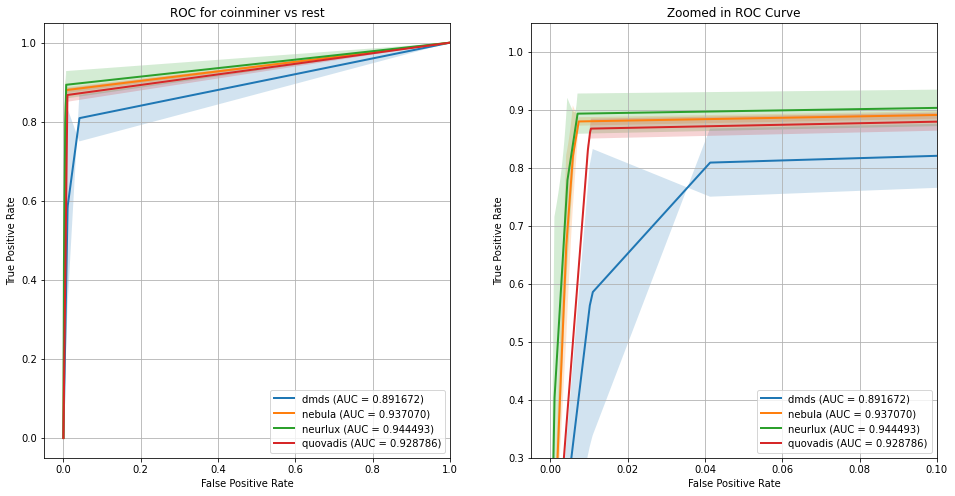

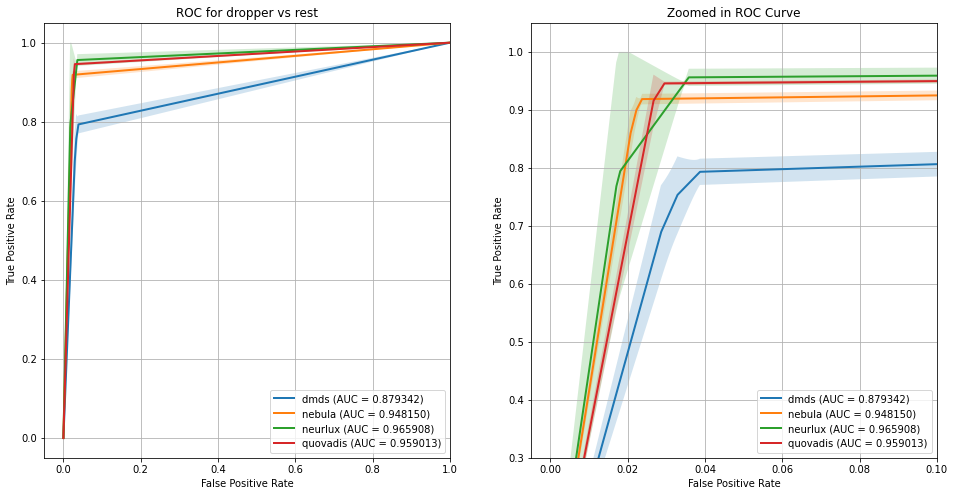

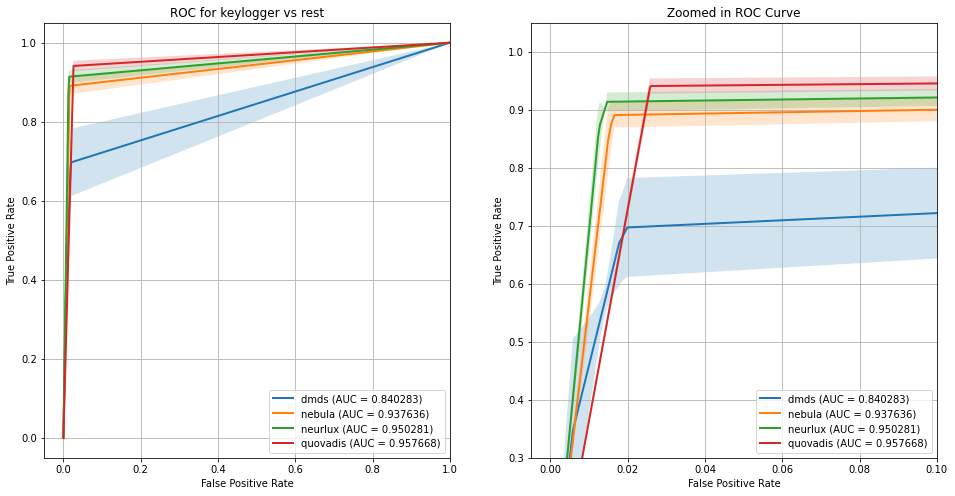

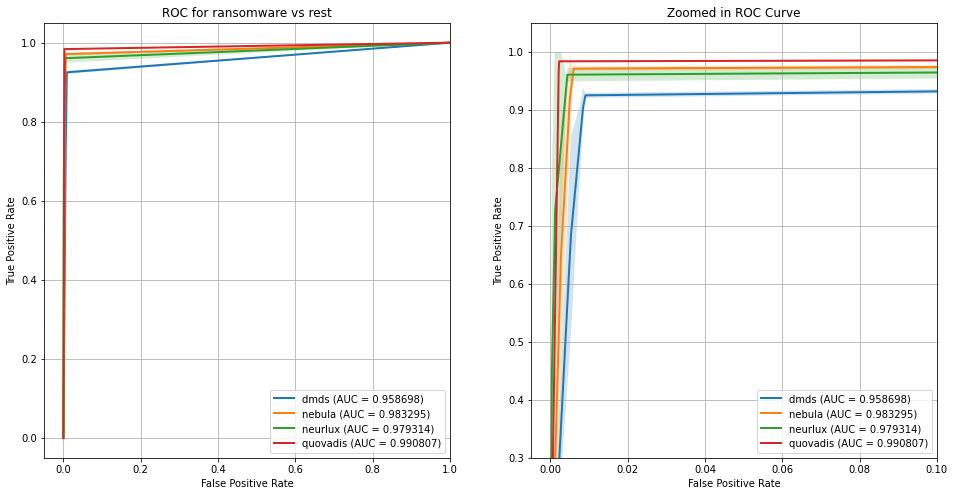

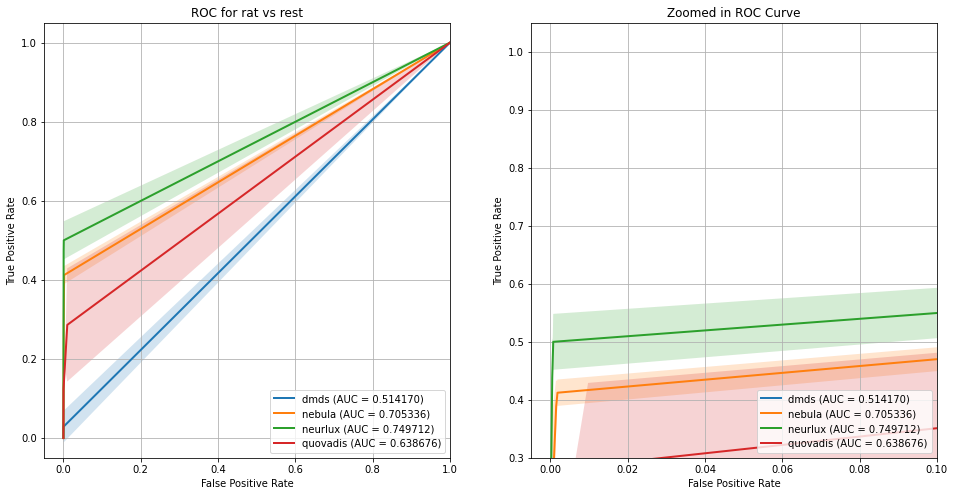

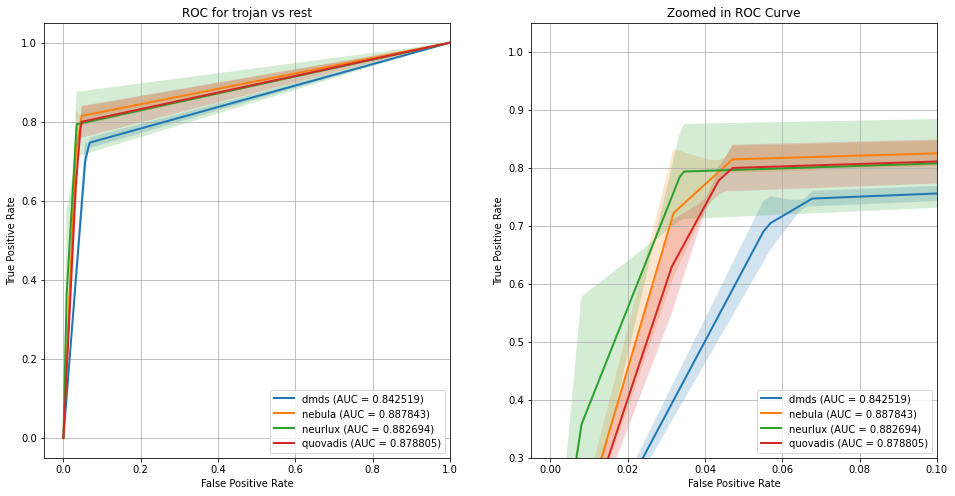

In [4]:
tprs_mean_val_all = dict(zip(models.keys(), [[] for _ in range(len(models))]))
tprs_std_val_all = dict(zip(models.keys(), [[] for _ in range(len(models))]))
for selected_label in SPEAKEASY_LABELMAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_val.items()}
    base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_label)

    df, axs_val = report_alligned_metrics(
        base_fpr_val,
        tprs_mean_val,
        tprs_std_val,
        metrics_label,
        xlim=[-0.005, 0.1],
        ylim=[0.3, 1.05],
        metrics_full=True
    )
    for k, v in tprs_mean_val.items():
        tprs_mean_val_all[k].append(v)
    for k, v in tprs_std_val.items():
        tprs_std_val_all[k].append(v)
    
    # suptitle to refer label
    axs_val[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[4:5].tolist() + df.columns[-5:].tolist()])

# take mean over all labels
for k, v in tprs_mean_val_all.items():
    tprs_mean_val_all[k] = np.mean(v, axis=0)
for k, v in tprs_std_val_all.items():
    tprs_std_val_all[k] = np.mean(v, axis=0)

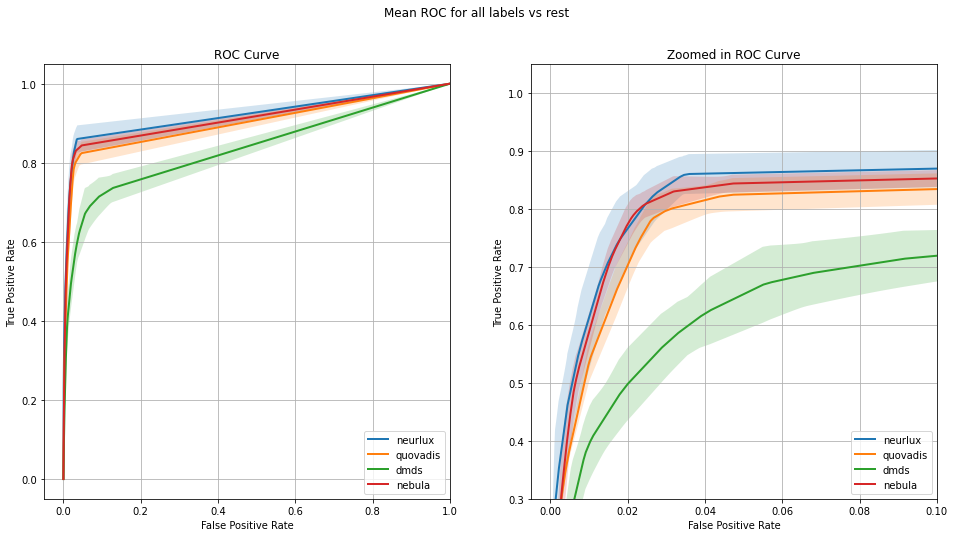

In [5]:
df, axs_val = report_alligned_metrics(
    base_fpr_val,
    tprs_mean_val_all,
    tprs_std_val_all,
    xlim=[-0.005, 0.1],
    ylim=[0.3, 1.05],
    metrics_full=False
)
# get fig of last plot
fig = axs_val[0].get_figure()
# suptitle to refer label
_ = fig.suptitle(f"Mean ROC for all labels vs rest")

## Test set ROCs

In [6]:
metrics_test = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = defaultdict(list)
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        try:
            data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and "vocab" in x][0]
        except IndexError:
            data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and not x.endswith(".pkl")][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))

        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_SPEAKEASY_LABELMAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                #print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics

clean
              0.01       AUC        F1    Recall  Precision  Accuracy
dmds      0.022942  0.748188  0.758818  0.899758   0.657691  0.736007
nebula    0.038209  0.855520  0.852634  0.963477   0.764701  0.846843
neurlux   0.034734  0.846400  0.845251  0.972889   0.747251  0.836234
quovadis  0.039514  0.838515  0.833750  0.911211   0.768742  0.832673
backdoor
              0.01       AUC        F1    Recall  Precision  Accuracy
dmds      0.410211  0.789360  0.686977  0.596220   0.861423  0.939450
nebula    0.785124  0.888982  0.854750  0.784364   0.939070  0.970280
neurlux   0.738174  0.866284  0.832900  0.736598   0.958201  0.967063
quovadis  0.774114  0.883894  0.852010  0.773024   0.949531  0.970050
coinminer
              0.01       AUC        F1    Recall  Precision  Accuracy
dmds      0.106564  0.785349  0.558558  0.642716   0.508632  0.900385
nebula    0.246825  0.770491  0.630264  0.565914   0.713992  0.935486
neurlux   0.491341  0.785783  0.691004  0.582740   0.849532  0.94

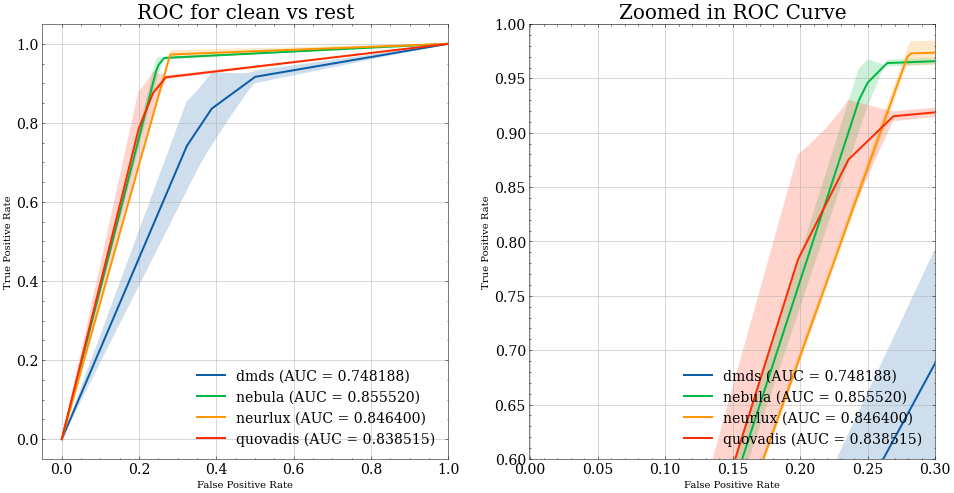

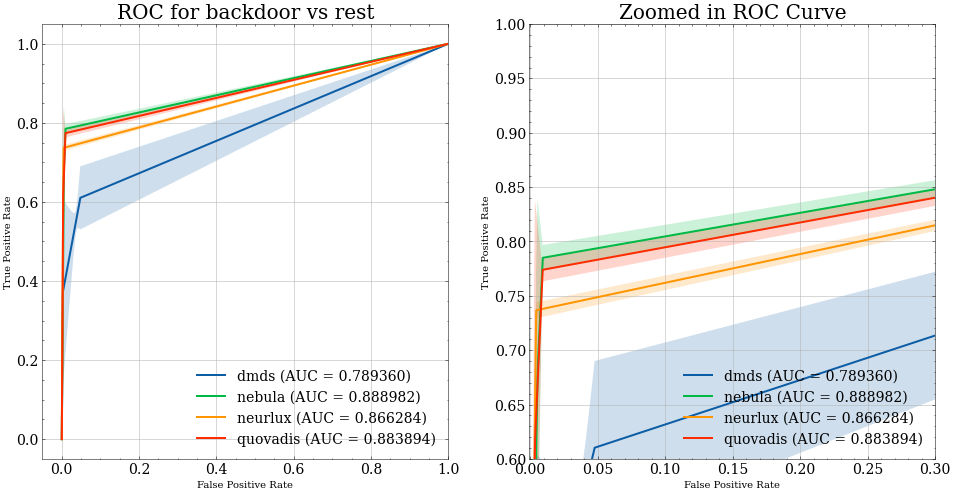

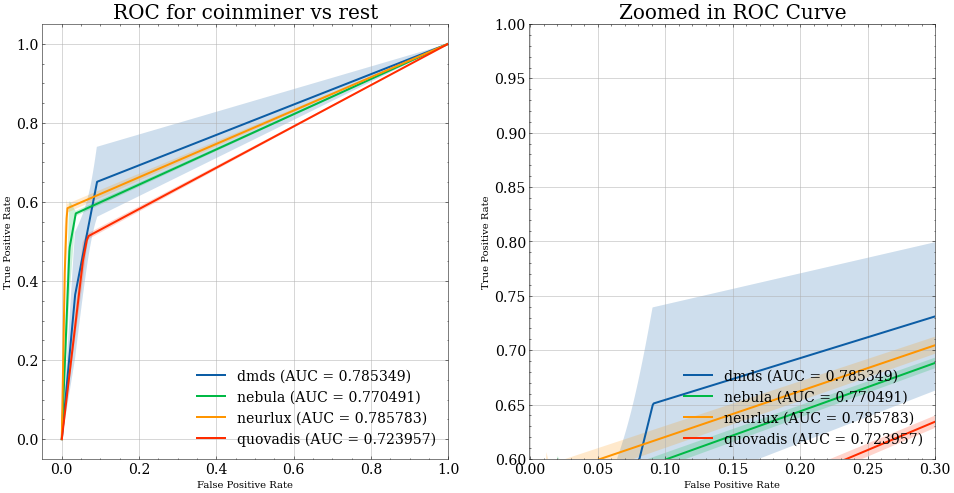

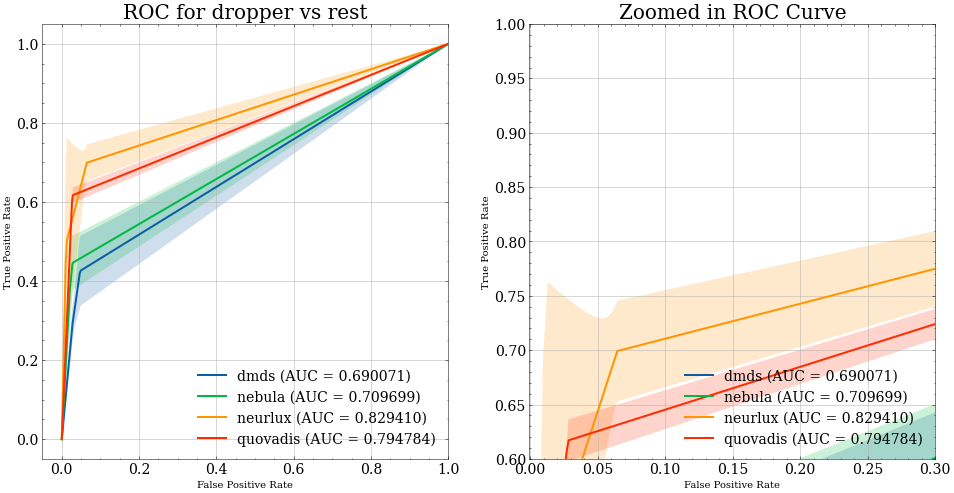

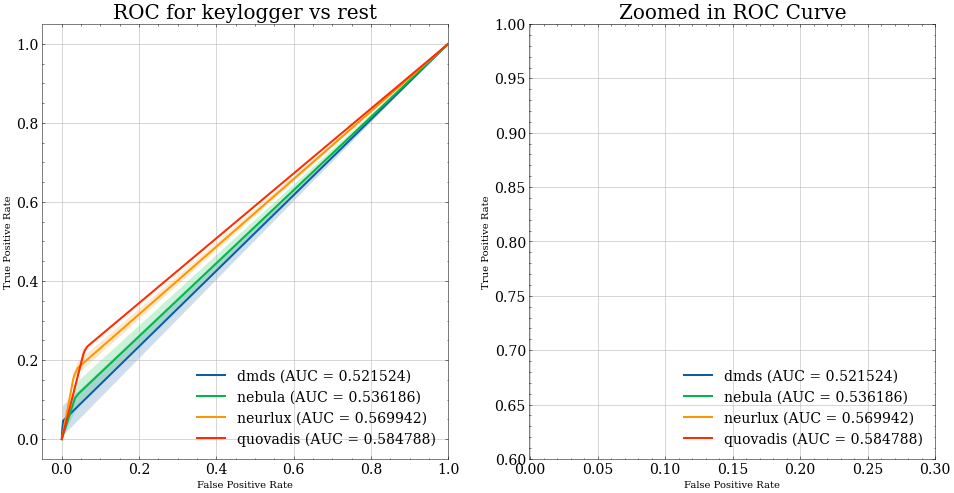

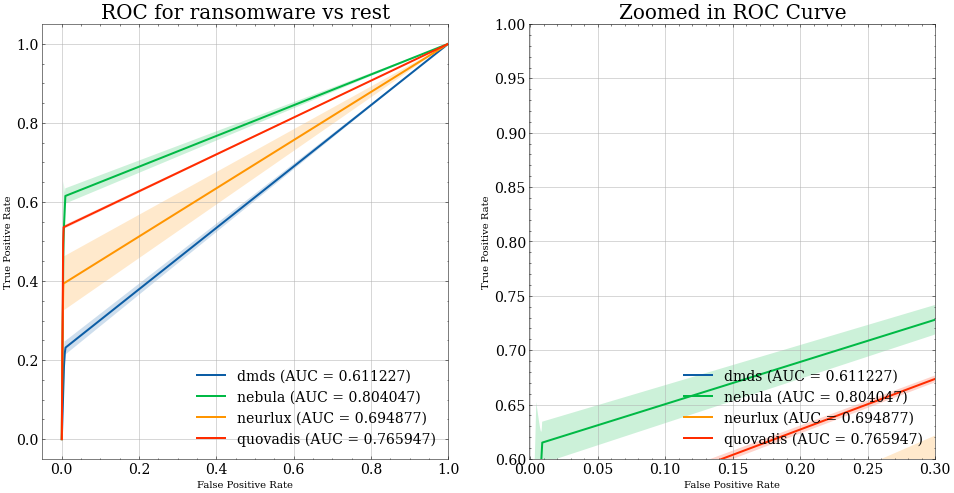

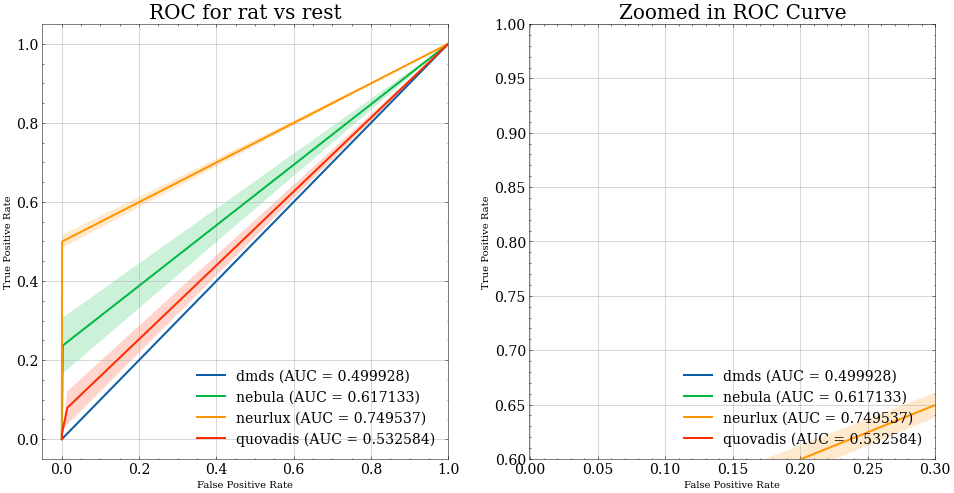

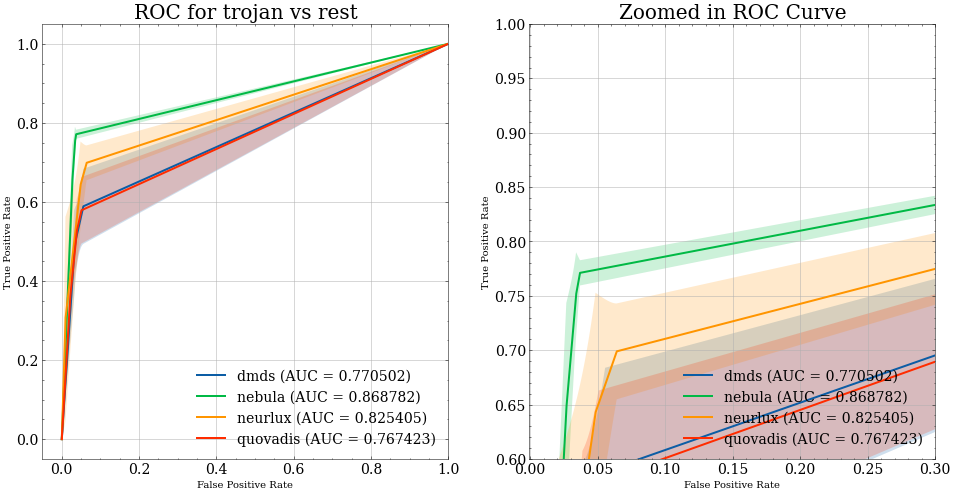

In [23]:
import pandas as pd
dfbar = pd.DataFrame()

tprs_mean_test_all = dict(zip(models.keys(), [[] for _ in range(len(models))]))
tprs_std_test_all = dict(zip(models.keys(), [[] for _ in range(len(models))]))
for selected_label in SPEAKEASY_LABELMAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_test.items()}
    base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_label)

    df, axs_test = report_alligned_metrics(
        base_fpr_test,
        tprs_mean_test,
        tprs_std_test,
        metrics_label,
        metrics_full=True
    )
    for k, v in tprs_mean_test.items():
        tprs_mean_test_all[k].append(v)
    for k, v in tprs_std_test.items():
        tprs_std_test_all[k].append(v)

    # suptitle to refer label
    axs_test[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[4:5].tolist() + df.columns[-5:].tolist()])
    # save f1 score for this label in dfbar
    f1series = df["F1"]
    dfbar[selected_label] = f1series

# take mean over all labels
for k, v in tprs_mean_test_all.items():
    tprs_mean_test_all[k] = np.mean(v, axis=0)
for k, v in tprs_std_test_all.items():
    tprs_std_test_all[k] = np.mean(v, axis=0)


In [30]:
dfbar

,clean,backdoor,coinminer,dropper,keylogger,ransomware,rat,trojan
dmds,0.758818,0.686977,0.558558,0.201513,0.079420,0.358425,0.000000,0.528229
nebula,0.852634,0.854750,0.630264,0.285044,0.129529,0.742148,0.368282,0.682707
neurlux,0.845251,0.832900,0.691004,0.448844,0.203185,0.552656,0.662516,0.615327
quovadis,0.833750,0.852010,0.488396,0.358026,0.211929,0.686104,0.119476,0.535911


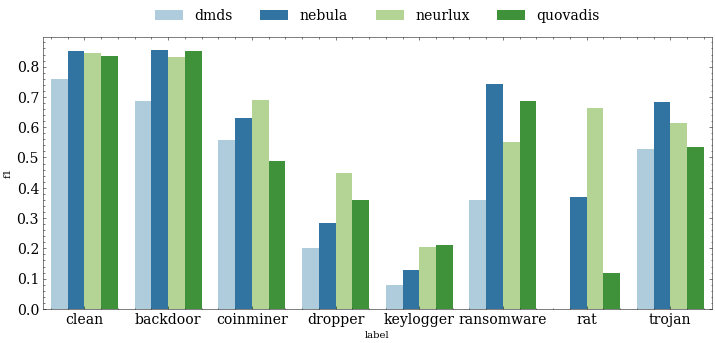

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_f1_barplots(df):
    """
        df.columns -- should be x axis
        df.index -- should be hue
        df.values -- f1 score, y axis
    """
    # prepare df
    dfbar = df.copy()
    dfbar = dfbar.reset_index()
    dfbar = dfbar.melt(id_vars=["index"], var_name="label", value_name="f1")
    dfbar = dfbar.rename(columns={"index": "model"})
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 5))
    # make colors more pleasant
    sns.set_palette("Paired")
    sns.barplot(
        x="label",
        y="f1",
        hue="model",
        data=dfbar,
        ax=ax
    )
    return ax
ax = plot_f1_barplots(dfbar)
#ax.set_yscale("log")
# legend above
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fancybox=True, shadow=True)

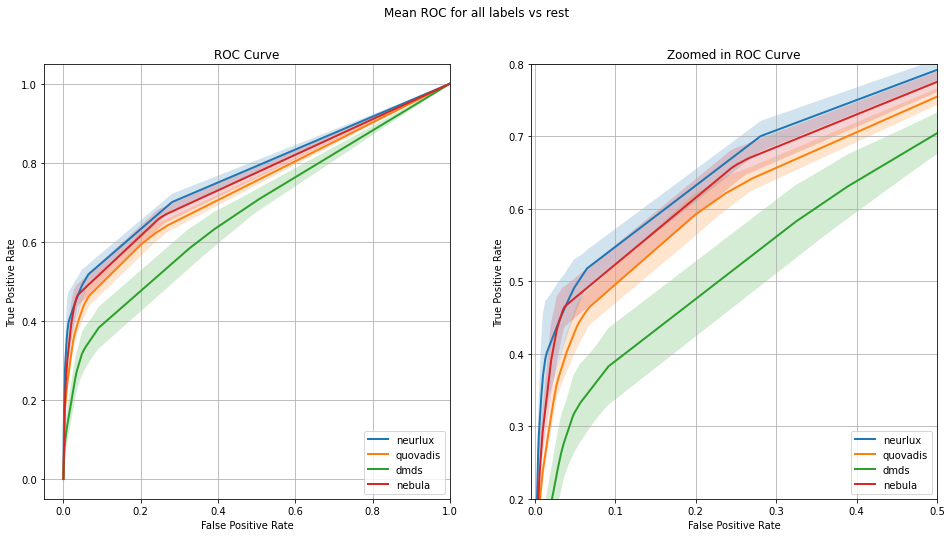

In [8]:
df, axs_test = report_alligned_metrics(
    base_fpr_test,
    tprs_mean_test_all,
    tprs_std_test_all,
    xlim=[-0.005, 0.5],
    ylim=[0.2, 0.8],
    metrics_full=False
)
# get fig of last plot
fig = axs_test[0].get_figure()
# suptitle to refer label
_ = fig.suptitle(f"Mean ROC for all labels vs rest")

In [9]:
def plot_science_roc(base_fpr, tprs_mean, tprs_std, filename, zoom_x=[-0.0001, 0.015], zoom_y=[0.9, 1.0], fontsize = 14):
    from nebula.misc.plots import plot_roc_curve, set_size
    import matplotlib.pyplot as plt
    import scienceplots
    plt.style.reload_library()
    plt.style.use(['science', 'no-latex'])
    plt.rcParams.update({'xtick.labelsize': fontsize,
                        'ytick.labelsize': fontsize,
                        # legend fontsize
                        'legend.fontsize': fontsize,
                        'axes.titlesize': 20,
                        })
    XLIM = [-0.02, 0.6]
    YLIM = [0.2, 1.02]

    value_map = {
        "dmds": r"Zhang et al.",
        "nebula": "Ours (BPE)",
        "nebula_bpe": "Ours (BPE)",
        "nebula_wht": "Ours (whitesp.)",
        "neurlux": r"Jindal et al.",
        "quovadis": r"Trizna"
    }

    fig, ax = plt.subplots(1, 1, figsize=set_size())
    if zoom_x or zoom_y:
        axin = ax.inset_axes([0.15, 0.1, 0.4, 0.4])
        axin.set_xticks([])
        axin.set_yticks([])

    for i, model_type in enumerate(tprs_mean_val_all.keys()):
        name = value_map[model_type]
        plot_roc_curve(
            base_fpr,
            tprs_mean[model_type],
            tprs_std[model_type],
            model_name=name,
            ax=ax,
            xlim=XLIM,
            ylim=YLIM
        )
        if zoom_x or zoom_y:
            plot_roc_curve(
                base_fpr,
                tprs_mean[model_type],
                tprs_std[model_type],
                model_name=name,
                ax=axin,
                xlim=zoom_x, 
                ylim=zoom_y
            )
    if zoom_x or zoom_y:
        ax.indicate_inset_zoom(axin)

    # get legend handles
    #handles, labels = ax.get_legend_handles_labels()
    #new_labels = ["Jindal et al.", "Zhang et al.", "Trizna", "Ours"]
    #new_handles = [handles[1], handles[3], handles[2], handles[0]]
    #ax.legend(new_handles, new_labels, loc='lower right')
    ax.legend(loc='lower right')
    ax.set_ylabel("True Positive Rate", fontsize=fontsize)
    ax.set_xlabel("False Positive Rate", fontsize=fontsize)

    # savefig as pdf in repo_root/img
    plt.savefig(os.path.join(REPO_ROOT, "img", filename), dpi=300, bbox_inches='tight')


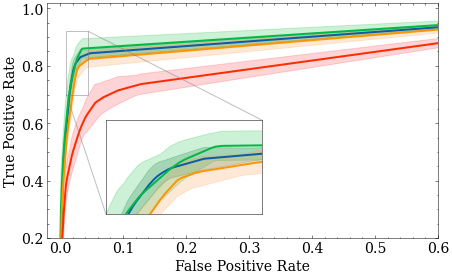

In [10]:
def plot_science_roc(base_fpr, tprs_mean, tprs_std, filename, zoom_x=[-0.0001, 0.015], zoom_y=[0.9, 1.0], fontsize = 14):
    from nebula.misc.plots import plot_roc_curve, set_size
    import matplotlib.pyplot as plt
    import scienceplots
    plt.style.reload_library()
    plt.style.use(['science', 'no-latex'])
    plt.rcParams.update({'xtick.labelsize': fontsize,
                        'ytick.labelsize': fontsize,
                        # legend fontsize
                        'legend.fontsize': fontsize,
                        'axes.titlesize': 20,
                        })
    XLIM = [-0.02, 0.6]
    YLIM = [0.2, 1.02]

    value_map = {
        "dmds": r"Zhang et al.",
        "nebula": "Ours (BPE)",
        "nebula_bpe": "Ours (BPE)",
        "nebula_wht": "Ours (whitesp.)",
        "neurlux": r"Jindal et al.",
        "quovadis": r"Trizna"
    }

    fig, ax = plt.subplots(1, 1, figsize=set_size())
    if zoom_x or zoom_y:
        axin = ax.inset_axes([0.15, 0.1, 0.4, 0.4])
        axin.set_xticks([])
        axin.set_yticks([])

    for model_type in ['nebula', 'neurlux', 'quovadis', 'dmds']:
        name = value_map[model_type]
        plot_roc_curve(
            base_fpr,
            tprs_mean[model_type],
            tprs_std[model_type],
            model_name=name,
            ax=ax,
            xlim=XLIM,
            ylim=YLIM
        )
        if zoom_x or zoom_y:
            plot_roc_curve(
                base_fpr,
                tprs_mean[model_type],
                tprs_std[model_type],
                model_name=name,
                ax=axin,
                xlim=zoom_x, 
                ylim=zoom_y
            )
    if zoom_x or zoom_y:
        _ = ax.indicate_inset_zoom(axin)
    # get legend handles
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ["Jindal et al.", "Zhang et al.", "Trizna", "Ours"]
    new_handles = [handles[1], handles[3], handles[2], handles[0]]
    #ax.legend(new_handles, new_labels, loc='lower right')
    # ax.legend(loc='lower right')
    ax.set_ylabel("True Positive Rate", fontsize=fontsize)
    ax.set_xlabel("False Positive Rate", fontsize=fontsize)

    # savefig as pdf in repo_root/img
    plt.savefig(os.path.join(REPO_ROOT, "img", filename), dpi=300, bbox_inches='tight')

plot_science_roc(base_fpr_val, tprs_mean_val_all, tprs_std_val_all, "roc_curve_speakeasy_multiclass_val.pdf", zoom_y=[0.7, 0.92], zoom_x=[0.01, 0.045])

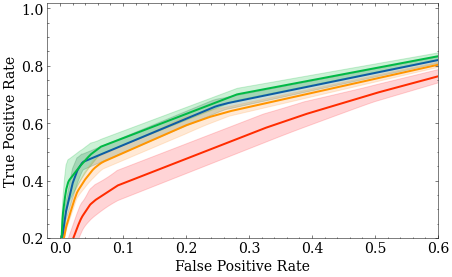

In [11]:
plot_science_roc(base_fpr_test, tprs_mean_test_all, tprs_std_test_all, "roc_curve_speakeasy_multiclass_test.pdf", zoom_x=None, zoom_y=None)

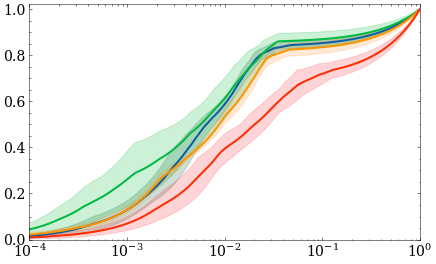

In [12]:
import matplotlib.pyplot as plt
from nebula.misc.plots import set_size

fig, ax = plt.subplots(1, 1, figsize=set_size())
for model_type in ['nebula', 'neurlux', 'quovadis', 'dmds']:
    plot_roc_curve(
        base_fpr_val,
        tprs_mean_val_all[model_type],
        tprs_std_val_all[model_type],
        model_name=model_type,
        ax=ax,
        semilogx=True,
        xlim=[0.0001, 1],
        ylim=[0, 1.02]
    )

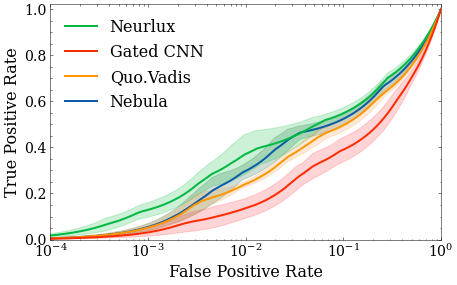

In [13]:
import matplotlib.pyplot as plt
from nebula.misc.plots import set_size

fig, ax = plt.subplots(1, 1, figsize=set_size())
for model_type in ['nebula', 'neurlux', 'quovadis', 'dmds']:
    plot_roc_curve(
        base_fpr_test,
        tprs_mean_test_all[model_type],
        tprs_std_test_all[model_type],
        model_name=model_type,
        ax=ax,
        semilogx=True,
        xlim=[0.0001, 1],
        ylim=[0, 1.02]
    )

handles, labels = ax.get_legend_handles_labels()
new_labels = ["Neurlux", "Gated CNN", "Quo.Vadis", "Nebula"]
new_handles = [handles[1], handles[3], handles[2], handles[0]]
ax.legend(new_handles, new_labels, fontsize=16)
#ax.legend(loc='lower right')
ax.set_ylabel("True Positive Rate", fontsize=16)
ax.set_xlabel("False Positive Rate", fontsize=16)

# savefig as pdf in repo_root/img
plt.savefig(os.path.join(REPO_ROOT, "img", "roc_curve_speakeasy_multiclass_test_logx.pdf"), dpi=300, bbox_inches='tight')

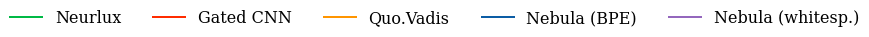

In [14]:
# import mlines
from matplotlib import lines as mlines

handles, labels = ax.get_legend_handles_labels()
new_labels = ["Neurlux", "Gated CNN", "Quo.Vadis", "Nebula (BPE)", "Nebula (whitesp.)"]
# create new handle with colo tab:purple and lw=2
handle = mlines.Line2D([], [], color='tab:purple', lw=2)
new_handles = [handles[1], handles[3], handles[2], handles[0], handle]

# create new ax for legend
figlegend = plt.figure(figsize=(10, 0.5))
axi = figlegend.add_subplot(111)
axi.legend(new_handles, new_labels, loc='center', ncol=5, fontsize=16)
# remove axis
axi.axis('off')

# save legend separately from plot as pdf in repo_root/img
plt.savefig(os.path.join(REPO_ROOT, "img", "roc_curve_multiclass_legend.pdf"), dpi=300, bbox_inches='tight')